In [14]:
from pathlib import Path
import pyforest
import utils
from typing import Callable
import scipy

In [23]:
def filtered_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 5
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


def naif_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    fft = np.fft.rfft(signal_matrix)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx


In [42]:
class BCIDataset():
    def __init__(
        self, csvs_path, subject: str = 'all', session: str = 'all',
        channel: str = 'all', overlapping_fraction: float = 1/3, window_size: int = 900,
        feature_extractor: Callable = naif_fft_features
    ):
        self.csvs_path = Path(csvs_path)
        self.channel = channel
        self.parts = int(1 / overlapping_fraction)
        self.fraction = 1 / self.parts
        self.ws = window_size
        self.subject = subject
        self.session = session
        self.channels = ['ch0','ch1','ch2','ch3']
        self.feature_extractor = feature_extractor
        self.complete_dataset = utils.read_all_datasets(self.csvs_path)
        
        self.complete_examples_signal, self.complete_examples_features, self.complete_labels, self.complete_metadata = \
            self.generate_examples()
        
    def generate_examples(self):
        # For each session generate the signal examples,
        # the feature extraction examples and labels arrays
        complete_examples_signal, complete_examples_features = [], []
        complete_labels, complete_metadata = [], []
        
        for subject in self.complete_dataset.subject.unique():
            # Just load the selected subjects
            if self.subject != 'all' and subject != self.subject:
                continue
            sessions = \
                self.complete_dataset.loc[self.complete_dataset.subject==subject].session.unique()
            for session in sessions:
                selection = self.complete_dataset.loc[
                    (self.complete_dataset.subject==subject) &
                    (self.complete_dataset.session==session)
                ]
                # Just load the selected session
                if self.session != 'all' and session != self.session:
                    continue
                    
                print(f'Processing subject: {subject} - session: {session}...')
                
                # Standarize length of the array to a multiple to window size
                labels = selection.label.values
                n_rows = labels.shape[0] // self.ws
                labels = labels[: n_rows * self.ws]

                # Generate examples from the signal
                n_examples = n_rows * self.parts
                examples = np.empty((n_examples, self.ws))
                most_frec_labels = np.empty((n_examples, self.ws))
                times = np.empty((n_examples, self.ws))
                
                concat_ch_examples_signal, concat_ch_examples_features = [], []

                for k, ch in enumerate(self.channels):
                    # Use the four channels or just one
                    if self.channel != 'all' and self.channel != ch:
                        continue
                    
                    # Standarize length of the signal to a multiple to window size
                    signal = selection[ch].values
                    signal = signal[: n_rows * self.ws]
                    time = selection.time.values
                    time = time[: n_rows * self.ws]

                    # Increase the number of examples by overlapping the windows
                    for part in range(self.parts):
                        
                        # Find the place in the output array for each example
                        position = np.arange(part, n_examples, self.parts)
                        position = position if part == 0 else position[:-part]

                        # Crop the signal according to the window size and overlap
                        start = int(self.ws / self.parts) * part
                        end = -int(self.ws - self.ws / self.parts) * part
                        end = end if end != 0 else signal.shape[0]
                        subset_signal = signal[start:end]
                        subset_labels = labels[start:end]
                        subset_times = time[start:end]

                        # Generate the examples
                        n_rows_ = int(subset_signal.shape[0]/self.ws)
                        examples[position, :] = subset_signal.reshape((n_rows_, self.ws))
                        most_frec_labels[position, :] = subset_labels.reshape((n_rows_, self.ws))
                        times[position, :] = subset_times.reshape((n_rows_, self.ws))
                    
                    # Obtain most frequent label
                    labels_ = scipy.stats.mode(most_frec_labels, axis=1).mode
                    pureness = dataset.labels_.count == 900
                    labels_temp = scipy.stats.mode(most_frec_labels, axis=1)
                    # Get first and last time of the window
                    times_ = np.asarray([np.min(times, axis=1), np.max(times, axis=1)]).T
                    # Extract features
                    features = self.feature_extractor(examples)

                    concat_ch_examples_signal.append(examples)
                    concat_ch_examples_features.append(features)

                concat_ch_examples_signal = np.concatenate(concat_ch_examples_signal, axis=1)
                concat_ch_examples_features = np.concatenate(concat_ch_examples_features, axis=1)

                complete_examples_signal.append(concat_ch_examples_signal)
                complete_examples_features.append(concat_ch_examples_features)
                complete_labels.append(labels_)
                lt = len(times_)
                metadata_ = np.concatenate(
                    [pureness, times_, np.repeat(subject, lt)[:,None], np.repeat(session, lt)[:,None]],
                    axis=1
                )
                complete_metadata.append(metadata_)

        complete_examples_signal = np.concatenate(complete_examples_signal)
        complete_examples_features = np.concatenate(complete_examples_features)
        complete_labels = np.concatenate(complete_labels)
        complete_metadata = np.concatenate(complete_metadata)
        
        return complete_examples_signal, complete_examples_features, complete_labels, complete_metadata
    
    def __len__(self):
        return self.complete_examples_signal.shape[0]
    
    def __getitem__(self, idx):
        return {
            'signal': self.complete_examples_signal[idx,:],
            'features': self.complete_examples_features[idx,:],
            'label': self.complete_labels[idx,:],
            'metadata': self.complete_metadata[idx,:]
        }

    def get_X_signal():
        return self.complete_examples_signal

    def get_X_features():
        return self.complete_examples_features

    def get_Y():
        return self.complete_labels

    def get_metadata():
        return self.complete_metadata


In [43]:
csvs_path = '/home/joaquin/Desktop/MentoriaDiploDatos/MetoriaBCI/Database'
dataset = BCIDataset(csvs_path, subject='AA', session='0')

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
metadata = pd.DataFrame(dataset.complete_metadata, columns = ['purness', 't_start', 't_end', 'subject', 'session'])

<IPython.core.display.Javascript object>

In [46]:
metadata.purness.value_counts()

True     87
False    66
Name: purness, dtype: int64

(0.0, 6.0)

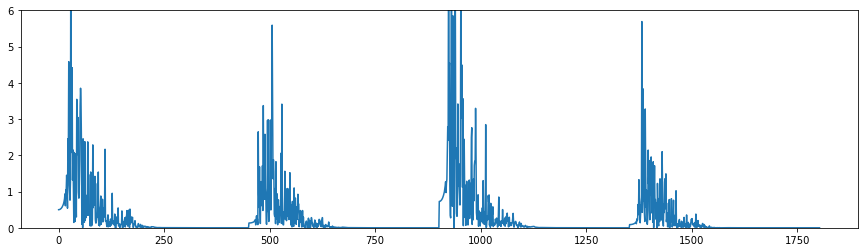

In [314]:
plt.figure(figsize=(15,4))
plt.plot(dataset.complete_examples_features[2,:])
plt.ylim([0,6])
# plt.xlim([8,40])